In [13]:
import json
import numpy as np
import pandas as pd
import os
import h5py
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt



## Importing the dataset

In [14]:
X = []
y = []
with h5py.File("datasets/robot_behaviors.hdf5", 'r') as ds:
    for i, key in enumerate(ds):
        print("Loading", key)
        X.append(ds[key][...])
        y.append(np.ones(ds[key].shape[0])*i)
        
        
X = np.concatenate(X, axis=0)
X[np.isnan(X)] = 0
y = np.concatenate(y, axis=0)

print(X.shape, y.shape)


#0         "/roboy/middleware/MotorStatus/displacement/3",
#1         "/roboy/middleware/MotorStatus/displacement/5",
#2         "/roboy/middleware/MotorStatus/displacement/6",
#3         "/roboy/middleware/MotorStatus/displacement/10",
#4         "/roboy/middleware/MotorStatus/displacement/12",
#5         "/roboy/middleware/MotorStatus/displacement/13",
#6         "/roboy/middleware/MotorStatus/position/3",
#7         "/roboy/middleware/MotorStatus/position/5",
#8         "/roboy/middleware/MotorStatus/position/6",
#9         "/roboy/middleware/MotorStatus/position/10",
#10         "/roboy/middleware/MotorStatus/position/12",
#11        "/roboy/middleware/MotorStatus/position/13",
#12         '/mocap/MarkerPose/position/x',
#13         '/mocap/MarkerPose/position/y',
#14         '/mocap/MarkerPose/position/z',

('Loading', u'frontal_swings_upwards')
('Loading', u'lateral_rotations_clockwise')
('Loading', u'marker_up')
('Loading', u'marker_up_frontal_swing')
('Loading', u'marker_up_lateral_rotations')
('Loading', u'marker_up_lateral_swing')
('Loading', u'motor_marker_1')
('Loading', u'random_motions')
((92514, 15), (92514,))


## Data Exploration

In [15]:
# End-Effector information (= motor camera image, (x,y,z))
Y_pos = X[:,12:]
# Motor position encodings
X_enc = X[:,6:12]
print(np.shape(Y_pos))
print(np.shape(X_enc))

(92514, 3)
(92514, 6)


In [16]:
import seaborn as sns
np.random.seed(sum(map(ord, "aesthetics")))

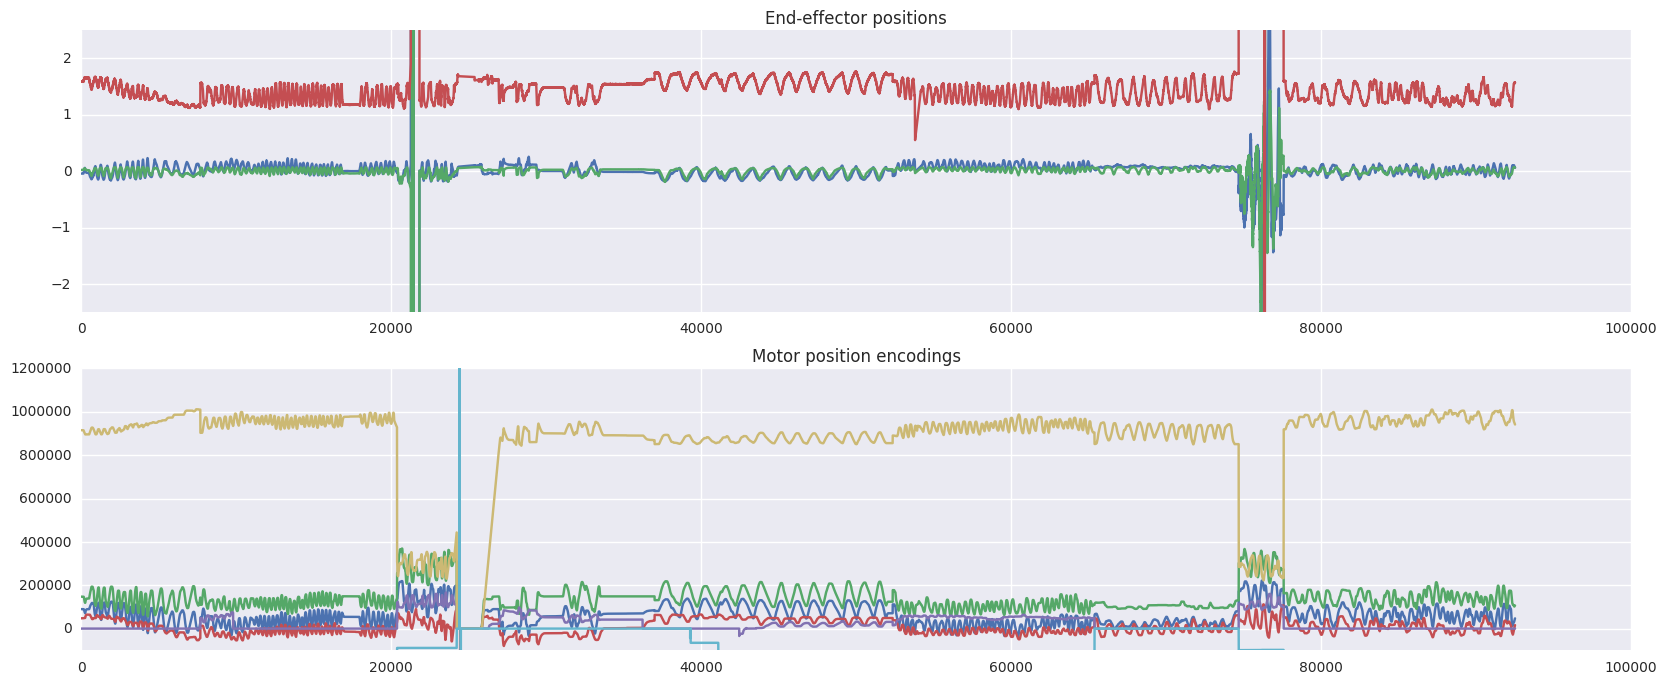

In [41]:
sns.set()
_, axes = plt.subplots(2,1,figsize=(20,8))
axes[0].plot(Y_pos)
axes[0].set_ylim([-2.5,2.5])
axes[0].set_title("End-effector positions")
axes[1].plot(X_enc)
axes[1].set_ylim([-100000,1200000])
axes[1].set_title("Motor position encodings")
plt.show()

# Sensory-Motor Learning for Inverse Kinematics

In [18]:
def predict_encodings(reg, Y_pos, X_enc):
    pred = reg.predict(Y_pos[90000:])
    plt.figure(figsize=(6,8)) # blue = ground truth; green= prediction

    for i in range(6):
        plt.subplot(6,1,i+1)
        plt.plot(X_enc[90000:,i]) # motor 1
        plt.plot(pred[:,i])

## SVM Regression

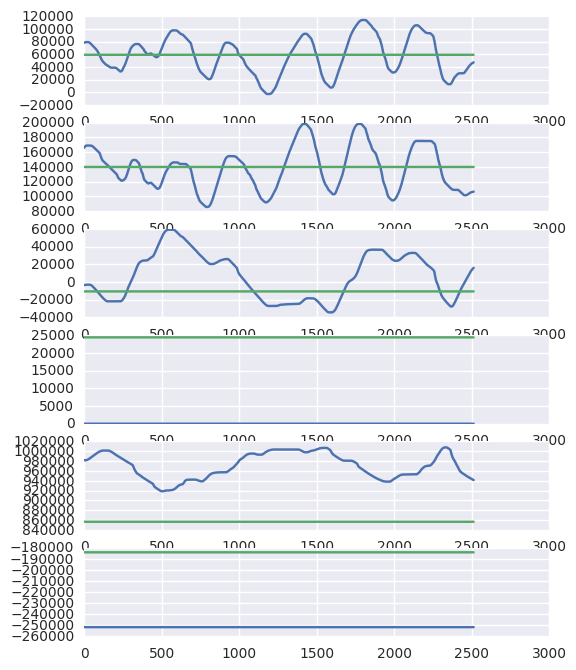

In [19]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(Y_pos[0:90000], X_enc[0:90000])
predict_encodings(reg,Y_pos,X_enc)

## Ridge Regression

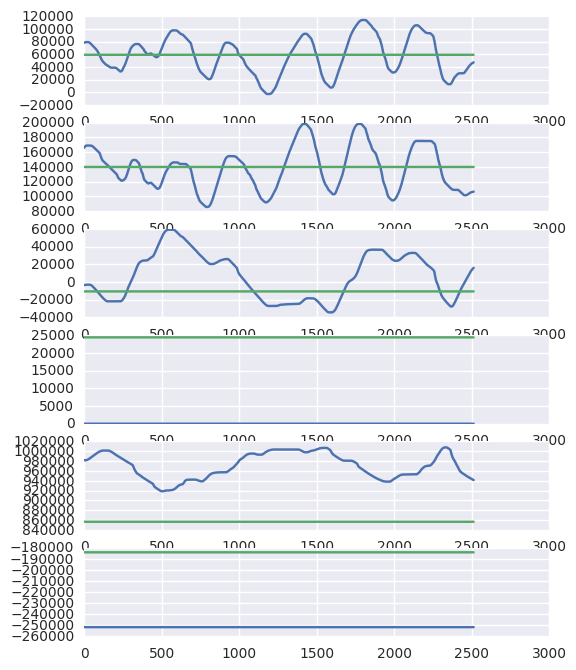

In [20]:
from sklearn import linear_model
reg = linear_model.Ridge()
reg.fit(Y_pos[0:90000], X_enc[0:90000])
predict_encodings(reg,Y_pos,X_enc)

# Sensory-Motor Learning for Forward Kinematics¶

In [21]:
def predict_positions(reg, Y_pos, X_enc):
    pred = reg.predict(X_enc[90000:])
    plt.figure(figsize=(6,8)) # blue = ground truth; green= prediction

    for i in range(3):
        plt.subplot(3,1,i+1)
        plt.plot(Y_pos[90000:,i]) # motor 1
        plt.plot(pred[:,i])

## SVM Regression

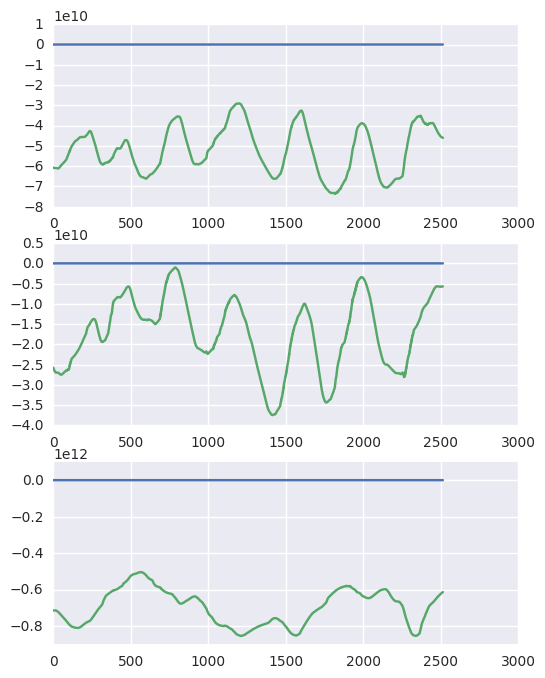

In [22]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_enc[0:90000], Y_pos[0:90000])
predict_positions(reg,Y_pos,X_enc)

# blue: predicted cartesian coordinate
# green: actual cartesian coordinate

# Let's try with a neural network

In [54]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()

model.add(Dense(units=64, activation='relu', input_shape=(6,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])

In [55]:
model.fit(X_enc[0:90000], Y_pos[0:90000], epochs=5, batch_size=32)

Epoch 1/5
90000/90000 [==============================] - 4s - loss: 27397885867111622138396672.0000 - mean_squared_error: 27397885867111622138396672.0000     
Epoch 2/5
90000/90000 [==============================] - 4s - loss: 27397885900900585122562048.0000 - mean_squared_error: 27397885900900585122562048.0000     
Epoch 3/5
90000/90000 [==============================] - 4s - loss: 27397885906626592571916288.0000 - mean_squared_error: 27397885906626592571916288.0000     
Epoch 4/5
90000/90000 [==============================] - 4s - loss: 27397885905968320114327552.0000 - mean_squared_error: 27397885905968320114327552.0000     
Epoch 5/5
90000/90000 [==============================] - 4s - loss: 27397885948079009867759616.0000 - mean_squared_error: 27397885948079009867759616.0000     


In [57]:
loss_and_metrics = model.evaluate(X_enc[90000:], Y_pos[90000:], batch_size=128)

 128/2514 [>.............................] - ETA: 1s

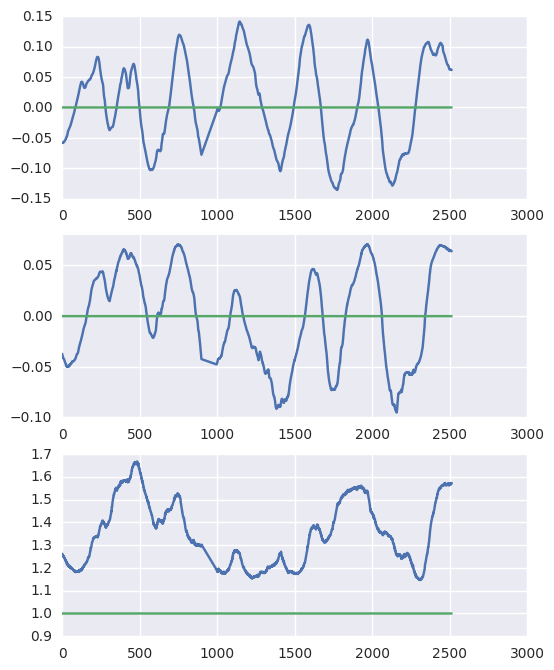

In [58]:
pred = model.predict(X_enc[90000:])
plt.figure(figsize=(6,8)) # blue = ground truth; green= prediction

for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(Y_pos[90000:,i]) # motor 1
    plt.plot(pred[:,i])

Every model seem to fit the data to a horizontal line. Possibly underfitting?

# Variational Autoencoder

Code from https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/variational_auto_encoder


Has not yet been adapted to our data...

In [3]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2))  # 2 for mean and variance.
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid())
    
    def reparameterize(self, mu, log_var):
        """"z = mean + eps * sigma where eps is sampled from N(0, 1)."""
        eps = to_var(torch.randn(mu.size(0), mu.size(1)))
        z = mu + eps * torch.exp(log_var/2)    # 2 for convert var to std
        return z
                     
    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)  # mean and log variance.
        z = self.reparameterize(mu, log_var)
        out = self.decoder(z)
        return out, mu, log_var
    
    def sample(self, z):
        return self.decoder(z)
  

In [ ]:
  
vae = VAE()

if torch.cuda.is_available():
    vae.cuda()
    
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
iter_per_epoch = len(data_loader)
data_iter = iter(data_loader)

# fixed inputs for debugging
fixed_z = to_var(torch.randn(100, 20))
fixed_x, _ = next(data_iter)
torchvision.utils.save_image(fixed_x.cpu(), './data/real_images.png')
fixed_x = to_var(fixed_x.view(fixed_x.size(0), -1))

for epoch in range(50):
    for i, (images, _) in enumerate(data_loader):
        
        images = to_var(images.view(images.size(0), -1))
        out, mu, log_var = vae(images)
        
        # Compute reconstruction loss and kl divergence
        # For kl_divergence, see Appendix B in the paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(out, images, size_average=False)
        kl_divergence = torch.sum(0.5 * (mu**2 + torch.exp(log_var) - log_var -1))
        
        # Backprop + Optimize
        total_loss = reconst_loss + kl_divergence
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print ("Epoch[%d/%d], Step [%d/%d], Total Loss: %.4f, "
                   "Reconst Loss: %.4f, KL Div: %.7f" 
                   %(epoch+1, 50, i+1, iter_per_epoch, total_loss.data[0], 
                     reconst_loss.data[0], kl_divergence.data[0]))
    
    # Save the reconstructed images
    reconst_images, _, _ = vae(fixed_x)
    reconst_images = reconst_images.view(reconst_images.size(0), 1, 28, 28)
    torchvision.utils.save_image(reconst_images.data.cpu(), 
'./data/reconst_images_%d.png' %(epoch+1))